In [1]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import multi_dot
import time

sys.path.insert(0, '..')

from pybandstructure import *

import graphene as gr

In [2]:
#################### graphene parameters #######################################
#distances in nm, energies in eV
#a = np.sqrt(3) *0.142
a = 0.246 #[nm] lattice constant of graphene
hv = 0.57 #hbar v_D [eV*nm]
t0 = -2.6755256377 #t0 = -3.089
hv = np.sqrt(3)/2 * a * abs(t0) 
print(hv)
uAB_nl = 0.#-0.2*uAB  #AB non-local interlayer coupling [eV]
uAA_nl = 0.#-0.2*uAA  #AA non-local interlayer coupling [eV]
valley = -1
Pietro = True
################################################################################
if Pietro:
    theta = 1.05 #twist angle [deg]
    uAB = 0.0975 #AB interlayer coupling [eV]
    uAA = 0.0797  #AA interlayer coupling [eV]
    density = 0.#0.001 #electron density in [nm^-2]
    temperature = 0.0004 #k_BT in eV
    eta = 0.0001 #energy smoothing [eV]
else:
    theta = 1.35 #twist angle [deg]
    uAB = 0.0975 #AB interlayer coupling [eV]
    uAA = 0.0797  #AA interlayer coupling [eV]
    density = 0.001 #electron density in [nm^-2]
    temperature = 0.0005 #k_BT in eV
    eta = 0.01 #energy smoothing [eV]
#################### computational parameters ##################################
n_sites = 24 # number of unit cells of the crystal in one direction !must be multiple of 6!
G_max = 3 #number of shells considered in reciprocal space
G_cut_off = 0
n_bands = 5 #number of bands calculated below and above Dirac point
####################### Output folder ##########################################
output_folder = 'test_output'
file_name = 'tblg'
################################################################################

0.5699999999982909


..\pybandstructure\sample\sample.py:551: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


Text(0, 0.5, '$k_y\\,[{\\rm nm^{-1}}]$')

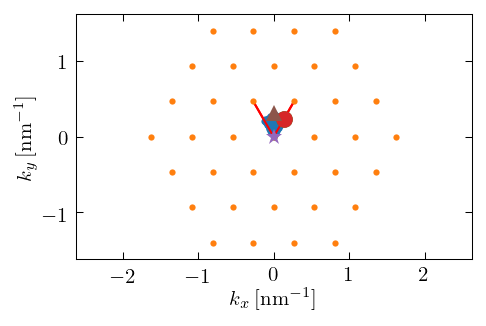

In [3]:
#lenght of reciprocal lattice vectors
G = 8. * np.pi * np.sin(theta / 360. * np.pi)/ (np.sqrt(3) * a)
#define reciprocal lattice basis
#reciprocal_lattice_basis = G * np.array([[          0.5,         -0.5],
#                                         [np.sqrt(3)/2.,np.sqrt(3)/2.]], dtype = float)

#special points
Mxy = int(n_sites/2)
Kxy = int(n_sites/3)

special_points = {'$\Gamma$': (0, 0), '$M$': (Mxy, 0), '$M^\prime$': (0, Mxy), '$K$': (Kxy, Kxy)}

#model = koshino(u0 = uAA, u1 = uAB, theta = theta, hv = hv, a = a, G_max = G_max)
model = koshino(valley = valley, uAA = uAA, uAB = uAB, uAA_nl = uAA_nl, uAB_nl = uAB_nl,
                            theta = theta, hv = hv, a = a, G_max = G_max)

point_group = Point_Group.dihedral_group(n = 3,theta0 = np.arctan2(model['reciprocal_lattice_vectors'].basis_vectors[1,0], 
                                                     model['reciprocal_lattice_vectors'].basis_vectors[0,0]))

#point_group = Point_Group.trivial_group(space_dimension=2)

lattice_geometry = Crystal_Geometry(reciprocal_lattice_basis = model['reciprocal_lattice_vectors'].basis_vectors, 
                                    point_group = point_group)

k_sample = Unit_Cell_Sample.irreducible_sample(name = '2D_Hexagonal_D3_Axes',
                                               basis_vectors= model['reciprocal_lattice_vectors'].basis_vectors, 
                                               denominator=n_sites)

#k_sample = Unit_Cell_Sample.wigner_seitz_cell(basis_vectors= model['reciprocal_lattice_vectors'].basis_vectors, 
#                                               denominator=n_sites, special_points=special_points)

q_sample = Unit_Cell_Sample.wigner_seitz_cell(basis_vectors= model['reciprocal_lattice_vectors'].basis_vectors, 
                                               denominator=n_sites, special_points=special_points)

#sampling of reciprocal lattice
reciprocal_lattice_vectors = Sample.lattice_sample(basis_vectors=model['reciprocal_lattice_vectors'].basis_vectors, cut_off=G * G_max)

G_sample = Sample.lattice_sample(basis_vectors=model['reciprocal_lattice_vectors'].basis_vectors, cut_off=G * G_cut_off)


#some plots
k_sample.plot()

reciprocal_lattice_vectors.plot()

plt.xlim(-G * G_max,G * G_max)
plt.ylim(-G * G_max,G * G_max)
plt.plot(*k_sample.get_coords((0,Mxy)),'o',ms=8)
plt.plot(*k_sample.get_coords((Mxy,0)),'o',ms=8)
plt.plot(*k_sample.get_coords((0,0)),'*',ms=8)
plt.plot(*k_sample.get_coords((Kxy,Kxy)),'^',ms=8)
plt.xlabel(r'$k_x\,[{\rm nm^{-1}}]$')
plt.ylabel(r'$k_y\,[{\rm nm^{-1}}]$')

Text(0, 0.5, '$q_y\\,[{\\rm nm^{-1}}]$')

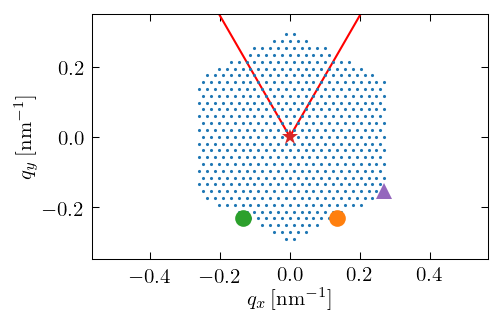

In [4]:
q_sample.plot(marker='.')
plt.xlim(-0.35,0.35)
plt.ylim(-0.35,0.35)
plt.plot(*q_sample.get_coords((0,Mxy)),'o',ms=8)
plt.plot(*q_sample.get_coords((Mxy,0)),'o',ms=8)
plt.plot(*q_sample.get_coords((0,0)),'*',ms=8)
plt.plot(*q_sample.get_coords((Kxy,Kxy)),'^',ms=8)
plt.plot(*q_sample.get_coords(2), 'x', ms=8)
plt.xlabel(r'$q_x\,[{\rm nm^{-1}}]$')
plt.ylabel(r'$q_y\,[{\rm nm^{-1}}]$')

In [5]:
#Density operator
U = np.kron(pauli_matrix(0),pauli_matrix(0))

matrices=[]
for i in range(len(G_sample)):
    matrices.append(build_potential_term(U=U, i=i, reciprocal_lattice_vectors = reciprocal_lattice_vectors))

coefficients = []
for i in range(len(matrices)):
    coefficients.append(lambda k,q: 1)
    
density_operator = []
for i in range(len(matrices)):
    density_operator.append(Operator(matrices=[matrices[i]], coefficients=[coefficients[i]], collapse=False, hermitian=True))


In [6]:
start = time.time()
####################### Output folder ##################################
output_folder = 'test_output/tblg'
file_name = '/tblg.hdf5'
########################################################################
########################################################################
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
try:
    os.remove(output_folder + file_name)
except:
    pass


band_structure = Band_Structure.from_hamiltonian(k_sample = k_sample, 
                                                 q_sample = q_sample,
                                                 G_sample = G_sample,
                                                 hamiltonian = model['hamiltonian'],
                                                 momentum_operator = model['momentum_operator'],
                                                 density_operator = density_operator,
                                                 degeneracy = 4,
                                                 zero_filling = n_bands,
                                                 density = density,
                                                 temperature = temperature)

band_structure.compute_bands(eigvals = (4 * len(model['reciprocal_lattice_vectors']) // 2 - n_bands,
                        4 * len(model['reciprocal_lattice_vectors']) // 2 + n_bands - 1))
band_structure.compute_momentum_matrix()
band_structure.compute_density_matrix()
tblg = Crystal(geometry = lattice_geometry,
                   band_structure=band_structure, eta = eta)
end = time.time()
print(end-start)

100%|██████████| 109/109 [00:22<00:00,  4.89it/s]


39.68038988113403


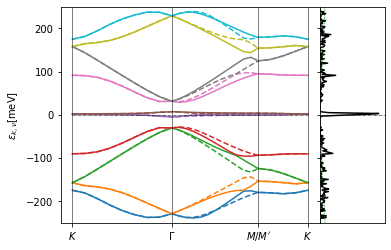

In [7]:
e_lims = -0.25,0.25 #energy limits for the figure
e_vals = np.linspace(*e_lims,num=250)

contour = tblg.band_structure.k_sample.contour([r'$K$', r'$\Gamma$', r'$M$', r'$K$'])
contour2 = tblg.band_structure.k_sample.contour([r'$K$', r'$\Gamma$', r'$M^\prime$', r'$K$'])
dosvals = tblg.dos(e_vals) #total dos by summing over band-resolved dos
################################################################################
#figure
plt.figure()
plt.axes([0.2,0.2,0.6,0.75])
#band plot
for i in range(2*n_bands):
    p = plt.plot(contour['x'],1e3*tblg.band_structure.energies[i,contour['indices']])
    plt.plot(contour['x'],1e3*tblg.band_structure.energies[i,contour2['indices']],'--', color = p[0].get_color())
#chemical potential
plt.plot([contour['x'][0],contour['x'][-1]],[tblg.band_structure.chemical_potential,tblg.band_structure.chemical_potential],'-.',c='k', lw=0.5)
#axes and limits
for point in contour['vertices']:
    plt.plot([contour['x'][point],contour['x'][point]],[1e3*e_vals[0],1e3*e_vals[-1]],lw=0.5, c='k')
#plt.plot([np.sqrt(3)/3+0.5,np.sqrt(3)/3+0.5],[1e3*e_vals[0],1e3*e_vals[-1]],lw=0.5, c='k')
plt.ylim(1e3*e_lims[0],1e3*e_lims[-1])
plt.ylabel(r'$\epsilon_{ k,\nu} [\rm meV]$')
plt.xticks(contour['x'][contour['vertices']],[r'$K$', r'$\Gamma$', r'$M/M^\prime$', r'$K$'])

#dos panel
ax = plt.axes([0.8,0.2,0.15,0.75])
ax.yaxis.set_label_position("right")
ax.set_xticks([])
ax.set_yticklabels([])
plt.ylim(1e3*e_lims[0],1e3*e_lims[-1])
plt.xlim(0,1.1*np.amax(dosvals)*1e-3)
plt.plot(1e-3*dosvals ,1e3*e_vals, c='k')
plt.plot(1e-3*abs(e_vals)*4/(np.pi * hv**2),1e3*e_vals,'--', c='g', lw=0.5)
plt.plot([0,1.1*np.amax(dosvals)*1e-3],[tblg.band_structure.chemical_potential,tblg.band_structure.chemical_potential],'-.',c='k', lw=0.5)

plt.savefig(output_folder +'/bands.pdf')

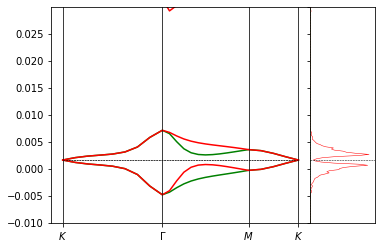

In [8]:
e_lims = -0.01,0.03 #energy limits for the figure
e_vals = np.linspace(*e_lims,num=200)
dosvals = tblg.dos(e_vals,shape = 'fermi')
plt.figure()
plt.axes([0.2,0.2,0.6,0.75])
_ = tblg.band_structure.plot([r'$K$', r'$\Gamma$', r'$M^\prime$', r'$K$'], c = 'g', emin = e_lims[0], emax=e_lims[1])
_ = tblg.band_structure.plot([r'$K$', r'$\Gamma$', r'$M$', r'$K$'], c = 'r',emin = e_lims[0], emax=e_lims[1])
plt.ylim(e_lims[0],e_lims[-1])
plt.yticks(np.arange(-0.01,0.03,0.005))
ax = plt.axes([0.8,0.2,0.15,0.75])
ax.yaxis.set_label_position("right")
ax.set_xticks([])
ax.set_yticklabels([])
plt.ylim(e_lims[0],e_lims[-1])
plt.xlim(0,1.1*np.amax(dosvals))
plt.plot(dosvals ,e_vals, c='r',lw=0.5)
plt.plot(abs(e_vals)*4/(np.pi * hv**2),e_vals,'--', c='g', lw=0.5)
plt.plot([0,1.1*np.amax(dosvals)],[tblg.band_structure.chemical_potential,tblg.band_structure.chemical_potential],'--',c='k', lw=0.5)

([<matplotlib.axis.XTick at 0x7fc17c951490>,
 [Text(0, 0, '$K$'),
  Text(0, 0, '$\\Gamma$'),
  Text(0, 0, '$M/M^\\prime$'),
  Text(0, 0, '$K$')])

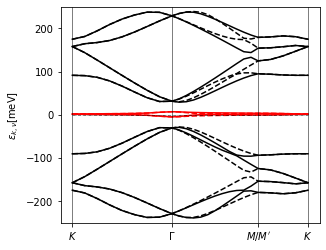

In [9]:
####- FLAT & REMOTE BANDS PLOT -#####
e_lims = -0.25,0.25 #energy limits for the figure
e_vals = np.linspace(*e_lims,num=250)

contour = tblg.band_structure.k_sample.contour([r'$K$', r'$\Gamma$', r'$M$', r'$K$'])
contour2 = tblg.band_structure.k_sample.contour([r'$K$', r'$\Gamma$', r'$M^\prime$', r'$K$'])
delta=1
evals=tblg.band_structure.energies[:,:]
remote_bands = np.concatenate([np.array(range(0,n_bands - delta),np.int_),np.array(range(n_bands + delta, evals.shape[0]),np.int_)])
flat_bands = np.concatenate([np.array(range(n_bands - delta, n_bands),np.int_),np.array(range(n_bands, n_bands + delta),np.int_)])

evals_remote = evals[remote_bands]
evals_flat = evals[flat_bands]

################################################################################
#figure
plt.figure()
plt.axes([0.2,0.2,0.6,0.75])
#remote band plot
for i in range(len(evals_remote)):
    p = plt.plot(contour['x'],1e3*evals_remote[i,contour['indices']], color='k')
    plt.plot(contour2['x'],1e3*evals_remote[i,contour2['indices']],'--', color = p[0].get_color())
#flat band plot
for i in range(len(evals_flat)):
    p = plt.plot(contour['x'],1e3*evals_flat[i,contour['indices']], color='r')
    plt.plot(contour2['x'],1e3*evals_flat[i,contour2['indices']],'--', color = p[0].get_color())
#chemical potential
plt.plot([contour['x'][0],contour['x'][-1]],[tblg.band_structure.chemical_potential,tblg.band_structure.chemical_potential],'-.',c='k', lw=0.5)
#axes and limits
for point in contour['vertices']:
    plt.plot([contour['x'][point],contour['x'][point]],[1e3*e_vals[0],1e3*e_vals[-1]],lw=0.5, c='k')

#plt.plot([np.sqrt(3)/3+0.5,np.sqrt(3)/3+0.5],[1e3*e_vals[0],1e3*e_vals[-1]],lw=0.5, c='k')
plt.ylim(1e3*e_lims[0],1e3*e_lims[-1])
plt.ylabel(r'$\epsilon_{ k,\nu} [\rm meV]$')
plt.xticks(contour['x'][contour['vertices']],[r'$K$', r'$\Gamma$', r'$M/M^\prime$', r'$K$'])

In [10]:
### Local Calculation comparison
omega_vals = np.linspace(eta,0.5,num=200)
omega_vals_eta = omega_vals + 1j*eta*np.ones(len(omega_vals))
q_ind = 1
print(tblg.band_structure.q_sample.get_coords(q_ind))
sigma_vals = tblg.local_conductivity(omega_vals)[:,0,0]

chi_vals = np.zeros(len(omega_vals), dtype =complex)
chi_vals_loc = ((sigma_vals/omega_vals_eta)
                *(-1.j)
                *(lin.norm(tblg.band_structure.q_sample.get_coords(q_ind)))**2)

chi_vals = tblg.polarization(omega_vals_eta,q_ind,0,0)

[-0.01125987  0.01950267]


../pybandstructure/crystal/analysis/conductivity_functions.py:8: RuntimeWarning: invalid value encountered in true_divide
  prefactor = -occupation_diff / energy_diff


ValueError: x and y must have same first dimension, but have shapes (200,) and (576, 401)

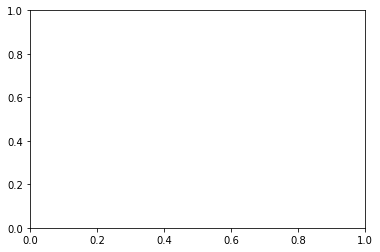

In [20]:
_ = plt.plot(omega_vals,np.real(chi_vals), label = r'Re$\chi$')
plt.plot(omega_vals,np.real(chi_vals_loc), '--', c = _[0].get_color(),lw = 0.5, label = r'Re$\chi$ local')

_ = plt.plot(omega_vals,np.imag(chi_vals), label = r'Im$\chi$')
plt.plot(omega_vals,np.imag(chi_vals_loc), '--', c = _[0].get_color(),lw = 0.5, label = r'Im$\chi$ local')

plt.vlines(eta, np.amin(chi_vals.real)-0.002, np.amax(chi_vals.imag)+0.002, colors='r', linestyles='--',lw=0.5, label='eta')
plt.vlines(-eta, np.amin(chi_vals.real)-0.002, np.amax(chi_vals.imag)+0.002, colors='r', linestyles='--',lw=0.5)


plt.xlim(0., 1)
plt.ylim(-0.05, 0.05)
plt.xlabel(r'$\hbar\omega$')
plt.title(r'Dynamical Polarization')
plt.legend()
plt.savefig(output_folder +'/chi_loc_compD3.pdf')

In [12]:
start = time.time()

#tblg.band_structure.eta=1e-4
#tblg.band_structure.temperature=0.0004
omega = np.linspace(-0.2, 0.2, 401)
omega = omega + 1j*np.ones(len(omega))*eta

#Evaluation of the remote bands contribution to dynamic polarization 
chi_vals = []
for q_ind in range(len(q_sample)):
    chi_vals.append(tblg.polarization(omega, q_ind, 0, 0, use_bands=remote_bands))
chi_remote = np.array(chi_vals)

#Evaluation of the flat bands contribution to dynamic polarization 
chi_vals = []
for q_ind in range(len(q_sample)):
    chi_vals.append(tblg.polarization(omega, q_ind, 0, 0, use_bands=flat_bands))
chi_flat = np.array(chi_vals)

end = time.time()
print(end-start)

162.56942510604858


In [13]:
#Evaluation of the full dynamic polarization 
chi_vals = []
for q_ind in range(len(q_sample)):
    chi_vals.append(tblg.polarization(omega, q_ind, 0, 0))
chi = np.array(chi_vals)

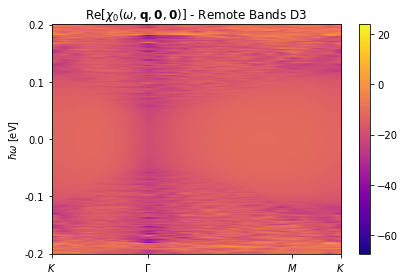

In [14]:
contour = [r'$K$', r'$\Gamma$', r'$M$',r'$K$' ]
plotting_contour = tblg.band_structure.q_sample.contour(contour)
index = plotting_contour["indices"]
distances = plotting_contour["x"]
points = plotting_contour["vertices"]


im = plt.imshow(chi_remote.real[index,:].T, origin = 'lower',aspect='auto',interpolation = 'bilinear', cmap='plasma')

plt.xticks(points, contour)
plt.xlim(min(points), max(points))
plt.yticks([0,100,200,300,400],[np.str(np.real(omega)[0]),np.str(np.real(omega)[100]),
                                               np.str(np.real(omega)[200]),np.str(round(np.real(omega)[300],2)),np.str(np.real(omega)[400])])
plt.ylabel(r'$\hbar\omega \;$[eV]')
plt.title(r'Re[$\chi_0(\omega,{\bf q}, {\bf 0}, {\bf 0})$] - Remote Bands D3')
#plt.gca().set_aspect(1 / plt.gca().get_data_ratio())#


plt.tight_layout()
plt.colorbar(im) # adding the colobar on the right
plt.savefig(output_folder +'/chireal_omega_q.pdf')
plt.show()


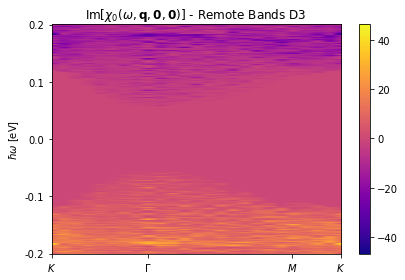

In [15]:
contour = [r'$K$', r'$\Gamma$', r'$M$',r'$K$' ]
plotting_contour = tblg.band_structure.q_sample.contour(contour)
index = plotting_contour["indices"]
distances = plotting_contour["x"]
points = plotting_contour["vertices"]

im = plt.imshow(chi_remote.imag[index,:].T, origin = 'lower',aspect='auto', cmap='plasma')#,interpolation = 'bilinear')#

plt.xticks(points, contour)
plt.xlim(min(points), max(points))#
plt.yticks([0,100,200,300,400],[np.str(np.real(omega)[0]),np.str(np.real(omega)[100]),
                                               np.str(np.real(omega)[200]),np.str(round(np.real(omega)[300],2)),np.str(np.real(omega)[400])])

plt.ylabel(r'$\hbar\omega \;$[eV]')
plt.title(r'Im[$\chi_0(\omega,{\bf q}, {\bf 0}, {\bf 0})$] - Remote Bands D3')
#plt.gca().set_aspect(1 / plt.gca().get_data_ratio())#

plt.tight_layout()
plt.colorbar(im) # adding the colobar on the right
plt.savefig(output_folder +'/chiimag_omega_q.pdf')
plt.show()


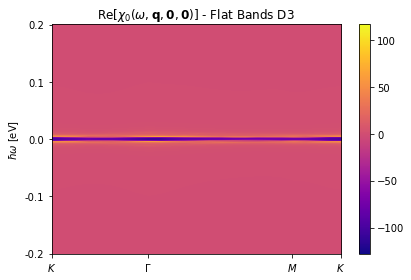

In [16]:
contour = [r'$K$', r'$\Gamma$', r'$M$',r'$K$' ]
plotting_contour = tblg.band_structure.q_sample.contour(contour)
index = plotting_contour["indices"]
distances = plotting_contour["x"]
points = plotting_contour["vertices"]


im = plt.imshow(chi_flat.real[index,:].T, origin = 'lower',aspect='auto',interpolation = 'bilinear', cmap='plasma')

plt.xticks(points, contour)
plt.xlim(min(points), max(points))
plt.yticks([0,100,200,300,400],[np.str(np.real(omega)[0]),np.str(np.real(omega)[100]),
                                               np.str(np.real(omega)[200]),np.str(round(np.real(omega)[300],2)),np.str(np.real(omega)[400])])
plt.ylabel(r'$\hbar\omega \;$[eV]')
plt.title(r'Re[$\chi_0(\omega,{\bf q}, {\bf 0}, {\bf 0})$] - Flat Bands D3')
#plt.gca().set_aspect(1 / plt.gca().get_data_ratio())#


plt.tight_layout()
plt.colorbar(im) # adding the colobar on the right
plt.savefig(output_folder +'/chireal_omega_q2.pdf')
plt.show()


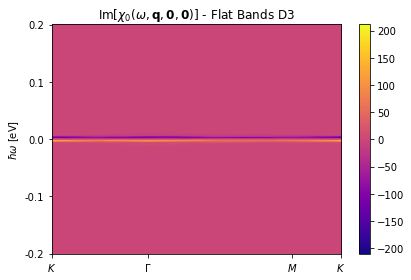

In [17]:
contour = [r'$K$', r'$\Gamma$', r'$M$',r'$K$' ]
plotting_contour = tblg.band_structure.q_sample.contour(contour)
index = plotting_contour["indices"]
distances = plotting_contour["x"]
points = plotting_contour["vertices"]

im = plt.imshow(chi_flat.imag[index,:].T, origin = 'lower',aspect='auto', cmap='plasma')#,interpolation = 'bilinear')#

plt.xticks(points, contour)
plt.xlim(min(points), max(points))#
plt.yticks([0,100,200,300,400],[np.str(np.real(omega)[0]),np.str(np.real(omega)[100]),
                                               np.str(np.real(omega)[200]),np.str(round(np.real(omega)[300],2)),np.str(np.real(omega)[400])])

plt.ylabel(r'$\hbar\omega \;$[eV]')
plt.title(r'Im[$\chi_0(\omega,{\bf q}, {\bf 0}, {\bf 0})$] - Flat Bands D3')
#plt.gca().set_aspect(1 / plt.gca().get_data_ratio())#

plt.tight_layout()
plt.colorbar(im) # adding the colobar on the right
plt.savefig(output_folder +'/chiimag_omega_q2.pdf')
plt.show()


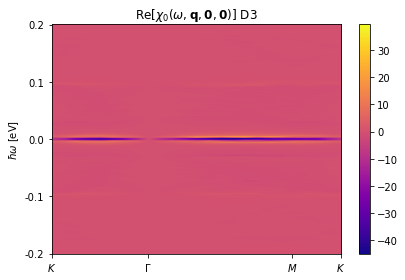

In [18]:
contour = [r'$K$', r'$\Gamma$', r'$M$',r'$K$' ]
plotting_contour = tblg.band_structure.q_sample.contour(contour)
index = plotting_contour["indices"]
distances = plotting_contour["x"]
points = plotting_contour["vertices"]


im = plt.imshow(chi.real[index,:].T, origin = 'lower',aspect='auto',interpolation = 'bilinear', cmap='plasma')

plt.xticks(points, contour)
plt.xlim(min(points), max(points))
plt.yticks([0,100,200,300,400],[np.str(np.real(omega)[0]),np.str(np.real(omega)[100]),
                                               np.str(np.real(omega)[200]),np.str(round(np.real(omega)[300],2)),np.str(np.real(omega)[400])])
plt.ylabel(r'$\hbar\omega \;$[eV]')
plt.title(r'Re[$\chi_0(\omega,{\bf q}, {\bf 0}, {\bf 0})$] D3')
#plt.gca().set_aspect(1 / plt.gca().get_data_ratio())#


plt.tight_layout()
plt.colorbar(im) # adding the colobar on the right
plt.savefig(output_folder +'/chireal_omega_q_full.pdf')
plt.show()


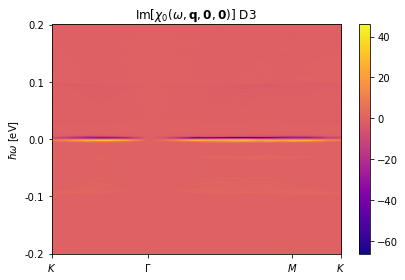

In [19]:
contour = [r'$K$', r'$\Gamma$', r'$M$',r'$K$' ]
plotting_contour = tblg.band_structure.q_sample.contour(contour)
index = plotting_contour["indices"]
distances = plotting_contour["x"]
points = plotting_contour["vertices"]

im = plt.imshow(chi.imag[index,:].T, origin = 'lower',aspect='auto', cmap='plasma')#,interpolation = 'bilinear')#

plt.xticks(points, contour)
plt.xlim(min(points), max(points))#
plt.yticks([0,100,200,300,400],[np.str(np.real(omega)[0]),np.str(np.real(omega)[100]),
                                               np.str(np.real(omega)[200]),np.str(round(np.real(omega)[300],2)),np.str(np.real(omega)[400])])

plt.ylabel(r'$\hbar\omega \;$[eV]')
plt.title(r'Im[$\chi_0(\omega,{\bf q}, {\bf 0}, {\bf 0})$] D3')
#plt.gca().set_aspect(1 / plt.gca().get_data_ratio())#

plt.tight_layout()
plt.colorbar(im) # adding the colobar on the right
plt.savefig(output_folder +'/chiimag_omega_q_full.pdf')
plt.show()
